## LIBRARIES

In [1]:
%matplotlib inline
import numpy as np
import os
import cv2

import matplotlib
import matplotlib.pyplot as plt
import math

import keras
from keras.layers import (Input, Activation, Conv3D, Dense, Dropout, Flatten,
                          MaxPooling3D, BatchNormalization, AveragePooling3D,
                          Reshape, Lambda, GlobalAveragePooling3D, Concatenate,
                          ReLU, Add)
from keras.losses import categorical_crossentropy
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file

from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
from keras.backend import set_session

from keras.callbacks import CSVLogger
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import os, warnings
from IPython.display import Video
#warnings.filters("Ignore")

2022-06-25 11:30:29.251827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-25 11:30:29.251858: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/sysadm/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
%run essential.py

In [3]:
%run slowfast.py

def resnet50(inputs, **kwargs):
    model = SlowFast_body(inputs, [3, 4, 6], bottleneck, **kwargs)
    return model

In [4]:
#%run essential.py
img_shape = 224
frame = 25

X, Y, input_shape = preprocess(video_dir = 'DCSASS_Dataset/', result_dir = 'output/',
                               nb_classes = 14, img_size =img_shape,frames = frame)
print("Input Shape = ", input_shape)

vid3d = Videoto3D(img_shape,img_shape,frame)

x = Input(shape = input_shape)
model = resnet50(x, num_classes=14)

model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(), 
                  metrics=['accuracy'])


X_shape:16639	Y_shape:(16639, 14)
Input Shape =  (25, 224, 224, 3)


2022-06-25 11:30:42.198983: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-25 11:30:42.199023: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-25 11:30:42.199047: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arya18): /proc/driver/nvidia/version does not exist
2022-06-25 11:30:42.199317: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, shuffle = True, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,test_size=0.15, shuffle = True,random_state=42)


print("X_train.shape = ", len(X_train))
print("X_val.shape = ", len(X_val))
print("X_test.shape = ", len(X_test))

X_train.shape =  12021
X_val.shape =  2122
X_test.shape =  2496


In [6]:
csv_logger = CSVLogger("Slowfast_all_model/slowfast_model_history_log.csv", append=True)

filepath="Slowfast_all_model/slowfast-{epoch:02d}-{val_accuracy:.2f}.hd5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
early_stop = EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 1,min_delta = 0.001)

callbacks_list = [checkpoint, csv_logger,early_stop]

In [7]:
batch_size = 8
model.summary()
history = model.fit(batchGenerator(X_train, Y_train, batch_size, vid3d),
                    steps_per_epoch = math.ceil(len(X_train) / batch_size),
                    validation_data = batchGenerator(X_val, Y_val, batch_size, vid3d),
                    validation_steps = math.ceil(len(X_val) / batch_size), epochs = 70, verbose = 1,
                    callbacks=callbacks_list, initial_epoch = 0)


model_json = model.to_json()

result_dir = 'output/'
if not os.path.isdir(result_dir):
    os.makedirs(result_dir)
with open(os.path.join(result_dir, 'slowfast.json'), 'w') as json_file:
    json_file.write(model_json)
model.save_weights(os.path.join(result_dir, 'slowfast_finalweights.hd5'))
model.save("slowfast_finalmodel.hd5")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 224, 22  0           []                               
                                4, 3)]                                                            
                                                                                                  
 data_fast (Lambda)             (None, 13, 224, 224  0           ['input_1[0][0]']                
                                , 3)                                                              
                                                                                                  
 sequential (Sequential)        (None, 13, 112, 112  5912        ['data_fast[0][0]']              
                                , 8)                                                          

Epoch 1/70
1503/1503 [==============================] - ETA: 0s - loss: 1.8016 - accuracy: 0.5449
Epoch 00001: saving model to Slowfast_all_model/slowfast-01-0.56.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-01-0.56.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 966s 636ms/step - loss: 1.8016 - accuracy: 0.5449 - val_loss: 1.8300 - val_accuracy: 0.5570
Epoch 2/70
1503/1503 [==============================] - ETA: 0s - loss: 1.6023 - accuracy: 0.5641
Epoch 00002: saving model to Slowfast_all_model/slowfast-02-0.57.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-02-0.57.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 954s 635ms/step - loss: 1.6023 - accuracy: 0.5641 - val_loss: 1.7670 - val_accuracy: 0.5683
Epoch 3/70
1503/1503 [==============================] - ETA: 0s - loss: 1.5414 - accuracy: 0.5684
Epoch 00003: saving model to Slowfast_all_model/slowfast-03-0.57.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-03-0.57.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 950s 632ms/step - loss: 1.5414 - accuracy: 0.5684 - val_loss: 1.5769 - val_accuracy: 0.5749
Epoch 4/70
1503/1503 [==============================] - ETA: 0s - loss: 1.4891 - accuracy: 0.5710
Epoch 00004: saving model to Slowfast_all_model/slowfast-04-0.53.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-04-0.53.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 942s 626ms/step - loss: 1.4891 - accuracy: 0.5710 - val_loss: 1.6437 - val_accuracy: 0.5278
Epoch 5/70
1503/1503 [==============================] - ETA: 0s - loss: 1.4148 - accuracy: 0.5818
Epoch 00005: saving model to Slowfast_all_model/slowfast-05-0.46.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-05-0.46.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 936s 622ms/step - loss: 1.4148 - accuracy: 0.5818 - val_loss: 1.8520 - val_accuracy: 0.4628
Epoch 6/70
1503/1503 [==============================] - ETA: 0s - loss: 1.3253 - accuracy: 0.5970
Epoch 00006: saving model to Slowfast_all_model/slowfast-06-0.56.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-06-0.56.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 918s 611ms/step - loss: 1.3253 - accuracy: 0.5970 - val_loss: 1.5590 - val_accuracy: 0.5580
Epoch 7/70
1503/1503 [==============================] - ETA: 0s - loss: 1.2027 - accuracy: 0.6277
Epoch 00007: saving model to Slowfast_all_model/slowfast-07-0.63.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-07-0.63.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 939s 625ms/step - loss: 1.2027 - accuracy: 0.6277 - val_loss: 1.1928 - val_accuracy: 0.6254
Epoch 8/70
1503/1503 [==============================] - ETA: 0s - loss: 1.0822 - accuracy: 0.6550
Epoch 00008: saving model to Slowfast_all_model/slowfast-08-0.53.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-08-0.53.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 921s 613ms/step - loss: 1.0822 - accuracy: 0.6550 - val_loss: 1.5398 - val_accuracy: 0.5311
Epoch 9/70
1503/1503 [==============================] - ETA: 0s - loss: 0.9759 - accuracy: 0.6896
Epoch 00009: saving model to Slowfast_all_model/slowfast-09-0.69.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-09-0.69.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 929s 618ms/step - loss: 0.9759 - accuracy: 0.6896 - val_loss: 0.9750 - val_accuracy: 0.6885
Epoch 10/70
1503/1503 [==============================] - ETA: 0s - loss: 0.8751 - accuracy: 0.7166
Epoch 00010: saving model to Slowfast_all_model/slowfast-10-0.66.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-10-0.66.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 923s 614ms/step - loss: 0.8751 - accuracy: 0.7166 - val_loss: 1.2385 - val_accuracy: 0.6645
Epoch 11/70
1503/1503 [==============================] - ETA: 0s - loss: 0.7999 - accuracy: 0.7399
Epoch 00011: saving model to Slowfast_all_model/slowfast-11-0.59.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-11-0.59.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 908s 604ms/step - loss: 0.7999 - accuracy: 0.7399 - val_loss: 1.3905 - val_accuracy: 0.5886
Epoch 12/70
1503/1503 [==============================] - ETA: 0s - loss: 0.7367 - accuracy: 0.7499
Epoch 00012: saving model to Slowfast_all_model/slowfast-12-0.68.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-12-0.68.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 931s 620ms/step - loss: 0.7367 - accuracy: 0.7499 - val_loss: 0.9881 - val_accuracy: 0.6800
Epoch 13/70
1503/1503 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.7673
Epoch 00013: saving model to Slowfast_all_model/slowfast-13-0.71.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-13-0.71.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 931s 619ms/step - loss: 0.6836 - accuracy: 0.7673 - val_loss: 0.8523 - val_accuracy: 0.7144
Epoch 14/70
1503/1503 [==============================] - ETA: 0s - loss: 0.6411 - accuracy: 0.7754
Epoch 00014: saving model to Slowfast_all_model/slowfast-14-0.72.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-14-0.72.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 917s 610ms/step - loss: 0.6411 - accuracy: 0.7754 - val_loss: 0.7888 - val_accuracy: 0.7229
Epoch 15/70
1503/1503 [==============================] - ETA: 0s - loss: 0.6044 - accuracy: 0.7884
Epoch 00015: saving model to Slowfast_all_model/slowfast-15-0.72.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-15-0.72.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 928s 618ms/step - loss: 0.6044 - accuracy: 0.7884 - val_loss: 0.8971 - val_accuracy: 0.7172
Epoch 16/70
1503/1503 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.7914
Epoch 00016: saving model to Slowfast_all_model/slowfast-16-0.75.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-16-0.75.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 911s 606ms/step - loss: 0.5720 - accuracy: 0.7914 - val_loss: 0.7730 - val_accuracy: 0.7484
Epoch 17/70
1503/1503 [==============================] - ETA: 0s - loss: 0.5329 - accuracy: 0.8070
Epoch 00017: saving model to Slowfast_all_model/slowfast-17-0.74.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-17-0.74.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 927s 617ms/step - loss: 0.5329 - accuracy: 0.8070 - val_loss: 0.7766 - val_accuracy: 0.7394
Epoch 18/70
1503/1503 [==============================] - ETA: 0s - loss: 0.5095 - accuracy: 0.8195
Epoch 00018: saving model to Slowfast_all_model/slowfast-18-0.73.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-18-0.73.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 925s 616ms/step - loss: 0.5095 - accuracy: 0.8195 - val_loss: 0.8111 - val_accuracy: 0.7253
Epoch 19/70
1503/1503 [==============================] - ETA: 0s - loss: 0.4733 - accuracy: 0.8260
Epoch 00019: saving model to Slowfast_all_model/slowfast-19-0.73.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-19-0.73.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 929s 618ms/step - loss: 0.4733 - accuracy: 0.8260 - val_loss: 0.7981 - val_accuracy: 0.7276
Epoch 20/70
1503/1503 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.8319
Epoch 00020: saving model to Slowfast_all_model/slowfast-20-0.75.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-20-0.75.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 911s 606ms/step - loss: 0.4617 - accuracy: 0.8319 - val_loss: 0.7412 - val_accuracy: 0.7535
Epoch 21/70
1503/1503 [==============================] - ETA: 0s - loss: 0.4239 - accuracy: 0.8454
Epoch 00021: saving model to Slowfast_all_model/slowfast-21-0.68.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-21-0.68.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 930s 619ms/step - loss: 0.4239 - accuracy: 0.8454 - val_loss: 1.0152 - val_accuracy: 0.6824
Epoch 22/70
1503/1503 [==============================] - ETA: 0s - loss: 0.4155 - accuracy: 0.8473
Epoch 00022: saving model to Slowfast_all_model/slowfast-22-0.76.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-22-0.76.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 933s 621ms/step - loss: 0.4155 - accuracy: 0.8473 - val_loss: 0.7319 - val_accuracy: 0.7554
Epoch 23/70
1503/1503 [==============================] - ETA: 0s - loss: 0.3922 - accuracy: 0.8496
Epoch 00023: saving model to Slowfast_all_model/slowfast-23-0.75.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-23-0.75.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 932s 620ms/step - loss: 0.3922 - accuracy: 0.8496 - val_loss: 0.7574 - val_accuracy: 0.7512
Epoch 24/70
1503/1503 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.8621
Epoch 00024: saving model to Slowfast_all_model/slowfast-24-0.79.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-24-0.79.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 924s 615ms/step - loss: 0.3651 - accuracy: 0.8621 - val_loss: 0.6521 - val_accuracy: 0.7893
Epoch 25/70
1503/1503 [==============================] - ETA: 0s - loss: 0.3644 - accuracy: 0.8632
Epoch 00025: saving model to Slowfast_all_model/slowfast-25-0.79.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-25-0.79.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 906s 603ms/step - loss: 0.3644 - accuracy: 0.8632 - val_loss: 0.6467 - val_accuracy: 0.7889
Epoch 26/70
1503/1503 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.8716
Epoch 00026: saving model to Slowfast_all_model/slowfast-26-0.79.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-26-0.79.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 931s 619ms/step - loss: 0.3325 - accuracy: 0.8716 - val_loss: 0.6571 - val_accuracy: 0.7936
Epoch 27/70
1503/1503 [==============================] - ETA: 0s - loss: 0.3213 - accuracy: 0.8761
Epoch 00027: saving model to Slowfast_all_model/slowfast-27-0.77.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-27-0.77.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 922s 613ms/step - loss: 0.3213 - accuracy: 0.8761 - val_loss: 0.7215 - val_accuracy: 0.7691
Epoch 28/70
1503/1503 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.8860
Epoch 00028: saving model to Slowfast_all_model/slowfast-28-0.76.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-28-0.76.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 930s 619ms/step - loss: 0.3073 - accuracy: 0.8860 - val_loss: 0.7540 - val_accuracy: 0.7648
Epoch 29/70
1503/1503 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.8894
Epoch 00029: saving model to Slowfast_all_model/slowfast-29-0.77.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-29-0.77.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 931s 620ms/step - loss: 0.2890 - accuracy: 0.8894 - val_loss: 0.8186 - val_accuracy: 0.7700
Epoch 30/70
1503/1503 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.8954
Epoch 00030: saving model to Slowfast_all_model/slowfast-30-0.77.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-30-0.77.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 914s 608ms/step - loss: 0.2777 - accuracy: 0.8954 - val_loss: 0.7628 - val_accuracy: 0.7710
Epoch 31/70
1503/1503 [==============================] - ETA: 0s - loss: 0.2666 - accuracy: 0.9004
Epoch 00031: saving model to Slowfast_all_model/slowfast-31-0.77.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-31-0.77.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 935s 622ms/step - loss: 0.2666 - accuracy: 0.9004 - val_loss: 0.7334 - val_accuracy: 0.7724
Epoch 32/70
1503/1503 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.9097
Epoch 00032: saving model to Slowfast_all_model/slowfast-32-0.80.hd5
INFO:tensorflow:Assets written to: Slowfast_all_model/slowfast-32-0.80.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1503/1503 [==============================] - 932s 620ms/step - loss: 0.2488 - accuracy: 0.9097 - val_loss: 0.7161 - val_accuracy: 0.7988
Epoch 00032: early stopping
INFO:tensorflow:Assets written to: slowfast_finalmodel.hd5/assets


/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/lib/python3/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


312/312 [==============================] - 156s 501ms/step - loss: 0.6444 - accuracy: 0.8073


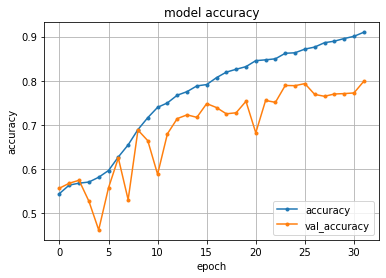

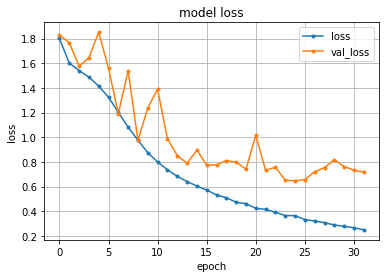

Test loss: 0.6444106101989746
Test accuracy: 0.8072916865348816


In [8]:
loss, acc = model.evaluate(batchGenerator(X_test, Y_test, batch_size, vid3d),
                           steps = math.ceil(len(X_test) / batch_size), verbose = 1)

plot_history(history, result_dir)

print('Test loss:', loss)
print('Test accuracy:', acc)

In [6]:
model = load_model('slowfast_finalmodel.hd5')

In [8]:
pred = []
label = []
for i in range(len(X_test)):
    #print(('DCSASS_Dataset_vid/'+vid+'.mp4'))
    vid = X_test[i]
    a = predictions(video_dir = 'DCSASS_Dataset_vid/'+vid+'.mp4', model = model)
    pred.append(a)
    #label.append(b)


Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 8 -- RoadAccidents
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 12 -- Stealing
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 8 -- RoadAccidents
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 4 -- Burglary
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 4 -- Burglary
Prediction - 7 -- Normal
Prediction - 0 -- Abuse
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 8 -- RoadAccidents
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 3 -- Assault
Prediction - 4 -- Burglary
Prediction - 12 -- Stealing
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction -

Prediction - 7 -- Normal
Prediction - 12 -- Stealing
Prediction - 1 -- Arrest
Prediction - 4 -- Burglary
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 2 -- Arson
Prediction - 4 -- Burglary
Prediction - 0 -- Abuse
Prediction - 2 -- Arson
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 1 -- Arrest
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 12 -- Stealing
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 

Prediction - 13 -- Vandalism
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 12 -- Stealing
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 10 -- Shooting
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 12 -- Stealing
Prediction - 12 -- Stealing
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 4 -- Burglary
Prediction - 7 -- Normal
Prediction - 3 -- Assault
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Pr

Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 9 -- Robbery
Prediction - 1 -- Arrest
Prediction - 7 -- Normal
Prediction - 2 -- Arson
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 6 -- Fighting
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 3 -- Assault
Prediction - 11 -- Shoplifting
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 12 -- Stealing
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 12 -- Stealing
Prediction - 7 -- Normal
Prediction - 10 -- Shooting
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 2 -- Arson
Prediction - 7 -- Normal
Pred

Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 4 -- Burglary
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 1 -- Arrest
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 12 -- Stealing
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 12 -- Stealing
Prediction - 0 -- Abuse
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 8 -- RoadAccidents
Prediction - 7 -- Normal
Prediction - 4 -- Burglary
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Pre

Prediction - 4 -- Burglary
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 6 -- Fighting
Prediction - 7 -- Normal
Prediction - 2 -- Arson
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 10 -- Shooting
Prediction - 0 -- Abuse
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 1 -- Arrest
Prediction - 9 -- Robbery
Prediction - 9 -- Robbery
Prediction - 12 -- Stealing
Prediction - 12 -- Stealing
Prediction - 4 -- Burglary
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 2 -- Arson
Prediction - 2 -- Arson
Prediction - 7 -- Normal
Prediction - 4 -- Burglary
Prediction - 7 -- Normal
Predi

Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 12 -- Stealing
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 13 -- Vandalism
Prediction - 12 -- Stealing
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 10 -- Shooting
Prediction - 10 -- Shooting
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 4 -- Burglary
Prediction - 9 -- Robbery
Prediction - 10 -- Shooting
Prediction - 9 -- Robbery
Prediction - 4 -- Burglary
Prediction - 2 -- Arson
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 3 -- Assault
Prediction - 6 -- Fighting
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 13 -- Vandalism
Prediction - 7 -- Normal
Prediction - 7 -

Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 10 -- Shooting
Prediction - 9 -- Robbery
Prediction - 4 -- Burglary
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 0 -- Abuse
Prediction - 4 -- Burglary
Prediction - 7 -- Normal
Prediction - 8 -- RoadAccidents
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 11 -- Shoplifting
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 12 -- Stealing
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 9 -- Robbery
Prediction - 7 -- Normal
Prediction - 0 -- Abuse
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 0 -- Abuse
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 2 -- Arson
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Prediction - 7 -- Normal
Pre

In [9]:
os.getcwd()

'/home/sysadm/Documents/Subhojit/FINAL'

In [10]:
test_label = np.argmax(Y_test, axis = 1)

In [11]:
label = sorted(os.listdir('DCSASS_Dataset/'))

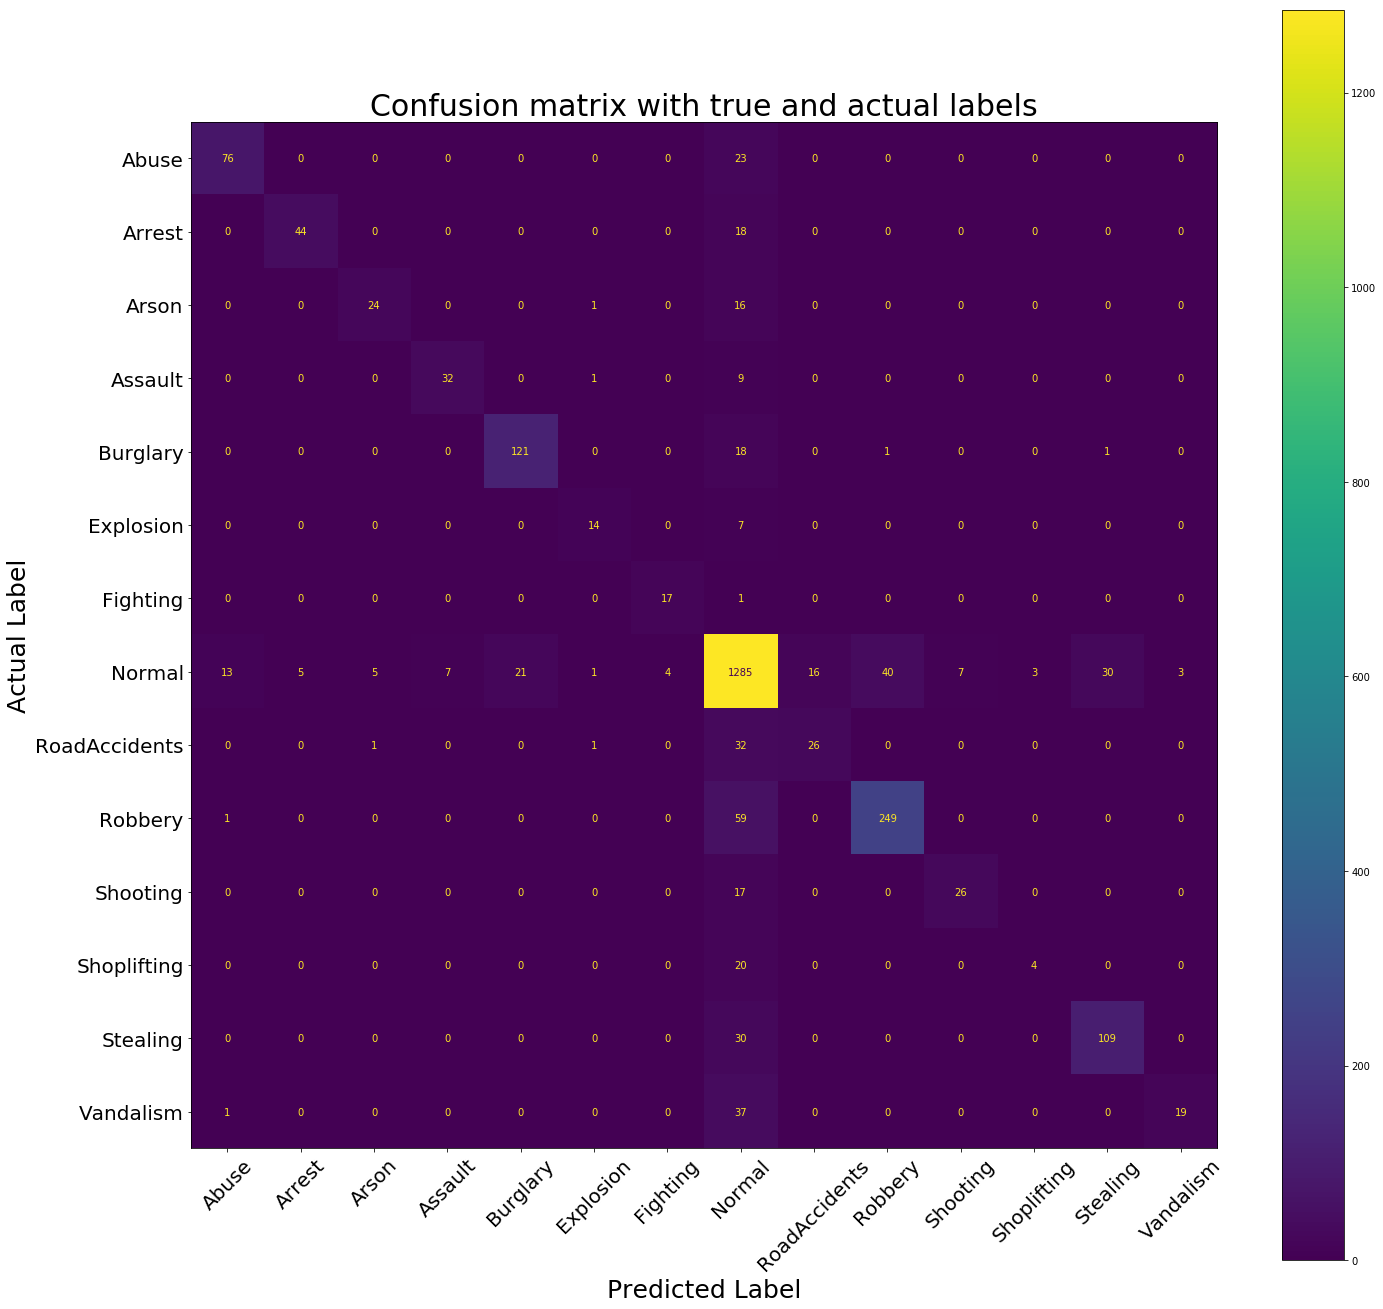

In [12]:
cm = confusion_matrix(test_label,pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=(np.arange(14)))
fig, ax = plt.subplots(figsize = (23,23))
ax.grid(False)
cmd.plot(ax = ax)
ax.xaxis.set_ticklabels(label, fontsize = 20, rotation = 45)
ax.yaxis.set_ticklabels(label, fontsize = 20)
ax.set_title("Confusion matrix with true and actual labels", fontsize = 30)
ax.set_xlabel("Predicted Label", fontsize = 25)
ax.set_ylabel("Actual Label", fontsize = 25)

plt.show()

### some visualization

In [22]:
Video("test4.mp4")

In [23]:
predictions(video_dir = 'test4.mp4', model = model)

Prediction - 1 -- Arrest


1

In [ ]:
results = model.predict(X_test)
results = np.argmax(results, axis = 1)
result_label = np.argmax(Y_test)

cm = confusion_matrix(Y_test, results)

In [3]:
model.compute_metrics()

In [ ]:
model.predict_generator()